## BOLFI examples

This notebook demonstrates how [BoTorch](https://botorch.org/) models and acquisition functions can be used in BOLFI with `BoTorchModel` and `BoTorchAcquisition` wrappers. For introduction to BOLFI, please read the [BOLFI tutorial](https://elfi.readthedocs.io/en/latest/usage/BOLFI.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import elfi
from botorch_wrapper import BoTorchModel, BoTorchAcquisition

### Basic example

The posterior estimation task considered in this notebook is the same task that is used in the BOLFI tutorial, but here we substitute the default model and acquisition method with `BoTorchModel` and `BoTorchAcquisition` instances.

- Task

In [2]:
from elfi.examples import ma2

In [3]:
seed = 1
m = ma2.get_model(seed_obs=seed)

We will use optimisation find simulator parameters that minimise the log-compressed distance:

In [4]:
log_d = elfi.Operation(np.log, m['d'])

The simulator model has two parameters:

In [5]:
m.parameter_names

['t1', 't2']

We set bounds on each parameter to define the search area considered in optimisation:

In [6]:
bounds = {'t1':(-2, 2), 't2':(-1, 1)}

- Model

`BoTorchModel` needs parameter names and bounds as input. We can also provide `model_options` which are passed on to the model class constructor documented [here](https://botorch.org/api/models.html#botorch.models.gp_regression.SingleTaskGP), but in this example we use the default options.

In [7]:
model = BoTorchModel(m.parameter_names, bounds, seed=seed)

`BoTorchModel` instances can be used with the acquisition methods available in ELFI, but optimisation is faster when the model is combined with a `BoTorchAcquisition` method.

- Acquisition method

`BoTorchAcquisition` needs an acquisition class and acquisition options as input. The options are passed on to the selected acquisition class constructor. Here we use the upper confidence bound acquisition rule:

In [8]:
from botorch.acquisition.analytic import UpperConfidenceBound
acq_class = UpperConfidenceBound

BoTorch assumes a maximisation problem while we have a minimisation task. This means that we must set the option `maximize` to `False`. In addition the selected acquisition class needs a parameter `beta`.

In [9]:
acq_options = {'beta': 20, 'maximize': False}

We can also define `optim_params` which is passed on to the optimisation method documented [here](https://botorch.org/api/optim.html#botorch.optim.optimize.optimize_acqf). The optimisation parameters include, for example, `num_restarts` which is comparable to the `n_inits` option in the acquisition functions in ELFI.

In [10]:
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})

- BOLFI

BOLFI options include `initial_evidence` and `update_interval` which determine when we start to use the acquisition method and how often we optimise the model fit to available data.

In [11]:
options = {'initial_evidence': 20, 'update_interval': 10, 'seed': seed}

Here we use the model and acquisition method that were created above.

In [12]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)

Run optimisation:

In [13]:
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 5.08 s, sys: 58 ms, total: 5.14 s
Wall time: 5.19 s


We can visualise the data collected in optimisation and see what has been learned about the dependencies between the model parameters and `log_d`:

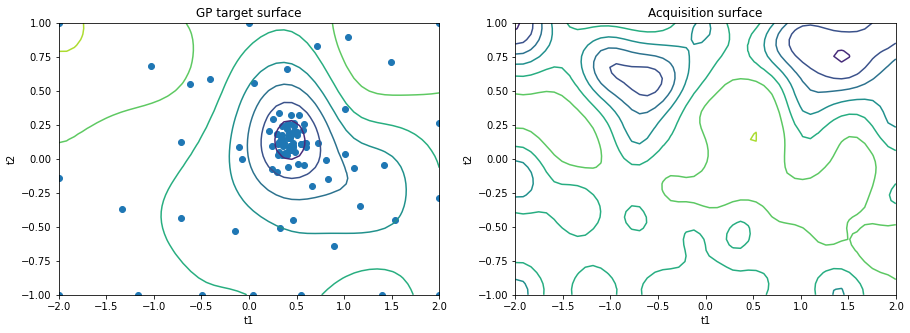

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

To conclude posterior estimation, we can use the fitted model to sample parameter combinations from the estimated approximate posterior. This can be slow.

In [15]:
%time res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
t1 1059.3868047000317 1.0085738340397001
t2 1817.3762848780111 1.002405543004739
CPU times: user 2min 5s, sys: 1.02 s, total: 2min 6s
Wall time: 2min 6s


In [16]:
res

Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -1.81
Parameter                Mean               2.5%              97.5%
t1:                     0.402             -0.257              0.886
t2:                     0.118             -0.328              0.573


This concludes the basic example. You can read more about the posterior sample in the [BOLFI tutorial](https://elfi.readthedocs.io/en/latest/usage/BOLFI.html). The next sections demonstrate some model and acquisition options that were not discussed above.

### Model options

The default model used in the above example is an exact Gaussian process model constructed with the default options documented [here](https://botorch.org/api/models.html#botorch.models.gp_regression.SingleTaskGP). The model can be customised with `model_options` that are passed on the constructor. In addition it is possible to use `model_constructor` and `model_optimizer` to substitute the defaults. However the default model with appropriate `model_options` is expected to cover most use cases.

The default options work best when the input parameters take values between 0 and 1 and the discrepancies have zero mean and unit variance. When this is not the case, we can use `model_options` to either normalise the data or pass on modules that better fit the data. Here we use normalisation.

In [17]:
import torch
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

We create an input transformation based on the search area bounds.

In [18]:
torch_bounds = torch.tensor(np.transpose([bounds[name] for name in m.parameter_names]))
input_transform = Normalize(len(m.parameter_names), bounds=torch_bounds)

The transformations are passed on to the model constructor as model options.

In [19]:
model_options = {'input_transform': input_transform, 'outcome_transform': Standardize(1)}
model = BoTorchModel(m.parameter_names, bounds, model_options=model_options, seed=seed)

Run optimisation:

In [20]:
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 5.88 s, sys: 72 ms, total: 5.95 s
Wall time: 5.98 s


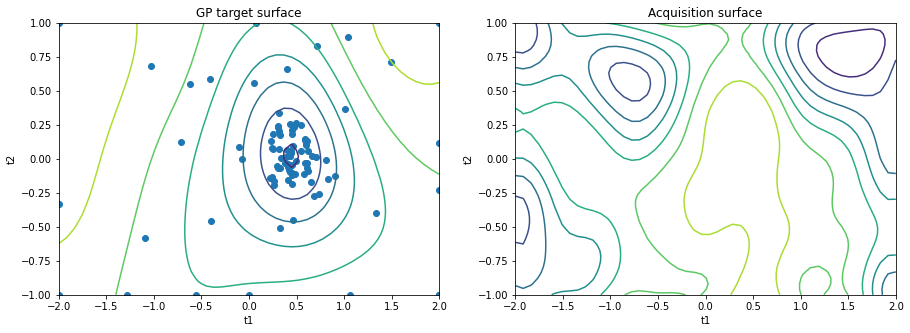

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

### Acquisition options

Some BoTorch acquisition classes take inputs that cannot be determined at the time when we initialise the `BoTorchAcquisition` wrapper. Examples include acquisition classes that need the current best observation or predicted minimum as input.

`BoTorchAcquisition` wrapper accepts acquisition options that need to be updated as functions that take a `BoTorchModel` instance as input and calculate the parameter value based on the current model state. To demonstrate, let us choose `beta` based on the current evidence count as proposed in [Srinivas et al (2010)](https://icml.cc/Conferences/2010/papers/422.pdf) (Theorem 1).

In [22]:
def beta_n(model):
    delta = 0.1
    return np.log(model.input_dim * np.power(model.n_evidence, 2) * np.power(np.pi, 2) / (6 * delta))

The function can now substitute the fixed `beta` in `acq_options`:

In [23]:
acq_options = {'beta': beta_n, 'maximize': False}

Create a new model and acquisition method instance:

In [24]:
model = BoTorchModel(m.parameter_names, bounds, model_options=model_options, seed=seed)
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})

Run optimisation:

In [25]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 5.8 s, sys: 58.9 ms, total: 5.85 s
Wall time: 5.87 s


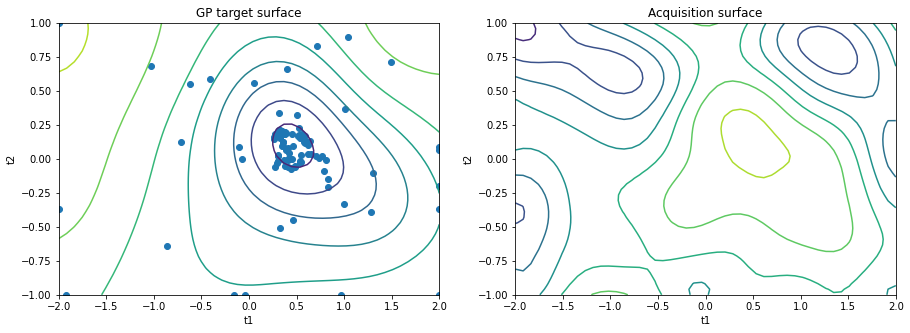

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

### Batch acquisitions

The acquisition method used in the above examples does not work with `batch_size` > 1. To make batch acquisitions based on the upper confidence bound rule, we must use:

In [27]:
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
acq_class = qUpperConfidenceBound
acq_options = {'beta': 20}

The reason we did not use this variant in the basic example is that the acquisition class does not have the `maximize` option that is used to support minimisation. Since this is the case with some acquisition classes, the model wrapper has an option `negate` that can be used instead.

In [28]:
model = BoTorchModel(m.parameter_names, bounds, negate=True, model_options=model_options, seed=seed)
acq_method = BoTorchAcquisition(model, acq_class, acq_options, optim_params={'num_restarts': 5})

Run optimisation:

In [29]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, batch_size=4, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 5.47 s, sys: 124 ms, total: 5.59 s
Wall time: 5.61 s


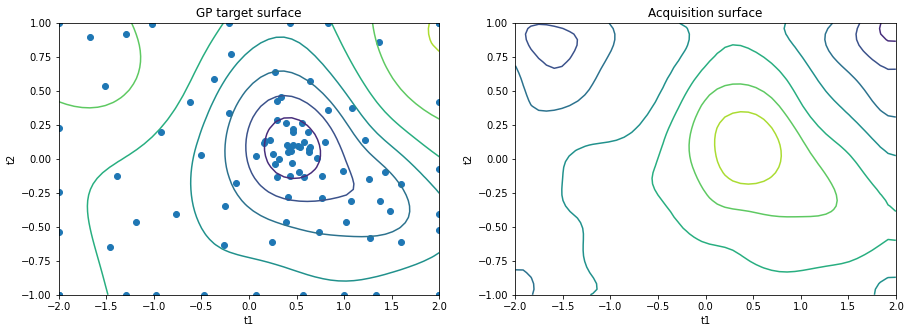

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();

### Constrained optimisation

The parameters considered in this notebook are associated with a prior distribution that is non-zero when $t_1 + t_2 > -1$ and $t_2 - t_1 > -1$.
This means that we are not interested in simulations outside this area and could constrain the search area considered in optimisation.

In [31]:
constraints = [(torch.tensor([0, 1]), torch.tensor([1, 1]), torch.tensor(-1)), (torch.tensor([0, 1]), torch.tensor([-1, 1]), torch.tensor(-1))]

The constraints are introduced into the acquisition method as optimisation parameters.

In [32]:
optim_params = {'num_restarts': 5, 'inequality_constraints': constraints}

Create a new model and acquisition method instance:

In [33]:
model = BoTorchModel(m.parameter_names, bounds, model_options=model_options, seed=seed)
acq_method = BoTorchAcquisition(model, UpperConfidenceBound, {'beta': 20, 'maximize': False}, optim_params=optim_params)

Run optimisation:

In [34]:
bolfi = elfi.BOLFI(log_d, target_model=model, acquisition_method=acq_method, **options)
%time post = bolfi.fit(n_evidence=100)

Progress [==================================================] 100.0% Complete
CPU times: user 1min 24s, sys: 1.05 s, total: 1min 25s
Wall time: 1min 25s


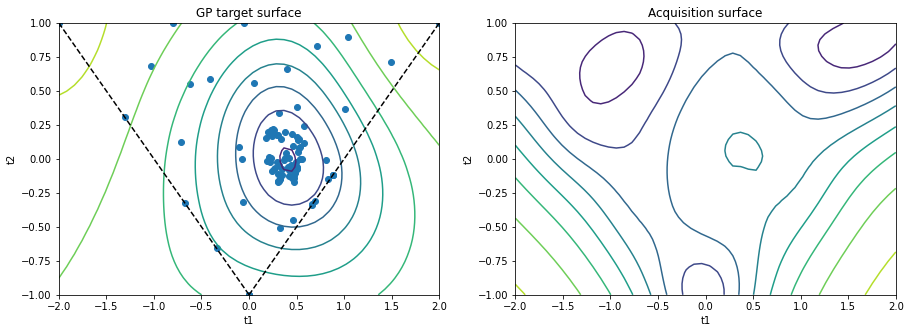

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bolfi.plot_state();
ax[0].plot(np.linspace(-2,2), (constraints[0][1][0]*np.linspace(-2,2)+constraints[0][2])/constraints[0][1][1], color='k', linestyle='--')
ax[0].plot(np.linspace(-2,2), (constraints[1][1][0]*np.linspace(-2,2)+constraints[1][2])/constraints[1][1][1], color='k', linestyle='--');